In [30]:
import pandas as pd
import datetime as dt

## Data Processing

In [31]:
### Merge data sets into one feature matrix

air_data = pd.read_csv("data/processed_air_quality_data")
weather_data = pd.read_csv("data/processed_weather_data_leuven")
noise_file40 = pd.read_csv("data/processed_file40_data")
noise_file41 = pd.read_csv("data/processed_file41_data")

# Dropping unncessary index columns and location (object id = location)
weather_data = weather_data.drop("Unnamed: 0", axis=1)
air_data = air_data.drop("Unnamed: 0", axis=1)
noise_file40 = noise_file40.drop(["Unnamed: 0", "location","result_timestamp"], axis=1)
noise_file41 = noise_file41. drop(["Unnamed: 0"], axis=1)

full_df = weather_data.merge(air_data, on=["date","hour","month","weekday"])
full_df = full_df.merge(noise_file40, on=["date","hour","month","weekday"])

# Merge on object_id is important
full_df = full_df.merge(noise_file41, on = ["date","hour","month","weekday","object_id"])


In [32]:
### Splitting into target_matrix and feature_matrix, train_set and test_set 
from sklearn.model_selection import train_test_split

# Selecting targets, dropping laf_features
target_list = ['Human voice - Shouting','Human voice - Singing', 'Music non-amplified',
       'Nature elements - Wind', 'Transport road - Passenger car', 'Transport road - Siren']
laf_features = ['laf005_per_hour','laf01_per_hour', 'laf05_per_hour', 'laf10_per_hour', 
                 'laf25_per_hour','laf50_per_hour', 'laf75_per_hour', 'laf90_per_hour', 
                 'laf95_per_hour','laf98_per_hour', 'laf99_per_hour', 'laf995_per_hour']
feature_list = [feature for feature in full_df.columns if feature not in target_list and feature not in laf_features]

# Dropping date features
date_features = ["time","date","dt"]
for feature in date_features:
    feature_list.remove(feature)

# Splitting in train/test
train_features, test_features, train_targets, test_targets = train_test_split(full_df[feature_list], 
                                                                              full_df[target_list], test_size=0.2, random_state=1337)


## Pipeline 

In [33]:
# Split in one_hot_var and numerical_var
# Need to add winddirection transformation
one_hot_var =["weathercode","hour","month","weekday","object_id"]
numerical_var = [col for col in train_features.columns if col not in one_hot_var]

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

t = ColumnTransformer(
    transformers = [
        ('OneHot', OneHotEncoder(handle_unknown='ignore'), one_hot_var),
        ('StandardScaler', StandardScaler(), numerical_var), 
        
    ] )

# fit the encoder
t.fit(train_features, train_targets)

ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['weathercode', 'hour', 'month', 'weekday',
                                  'object_id']),
                                ('StandardScaler', StandardScaler(),
                                 ['temperature_2m', 'relativehumidity_2m',
                                  'dewpoint_2m', 'apparent_temperature',
                                  'pressure_msl', 'surface_pressure',
                                  'precipitation', 'rain', 'snowfall',
                                  'cloudcover', 'cloudcover_low',
                                  'cloudcover_mid', 'cloudcover_high',
                                  'shortwave_radiation', 'direct_radiation',
                                  'diffuse_radiation',
                                  'direct_normal_irradiance', 'windspeed_10m',
                                  'winddirection_10m

In [35]:
# create pandas DataFrame from dense matrix
# To array because we may run into version troubles otherwise
X_train = pd.DataFrame(t.transform(train_features), columns=t.get_feature_names_out())

X_val = pd.DataFrame(t.transform(test_features), columns=t.get_feature_names_out())

## Model

### XGB 

In [36]:
import xgboost
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
model_params = {
    'xgboost': {
        'model': xgboost.XGBRegressor(),
            'params': {
                'n_estimators': randint(50, 100),
                'learning_rate': uniform(0.01, 0.5),
                'max_depth': randint(1, 10),
                'min_child_weight': randint(1, 10),
                'gamma': uniform(0, 1),
                'reg_alpha': uniform(0, 1),
                'reg_lambda': uniform(0, 1),
            }
        }
}
params_dict = {}
# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, train_targets)

    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.26387083903789865, 'learning_rate': 0.053371714919995976, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 88, 'reg_alpha': 0.6792299961209405, 'reg_lambda': 0.8037390361043755}
Best score for xgboost:  0.16154881005515578




In [37]:
import matplotlib as plt
xgb_params = params_dict['xgboost']
xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, train_targets)
predict_val = xgb.predict(X_val)


In [38]:
import numpy as np
round_predict = np.round(predict_val,0)

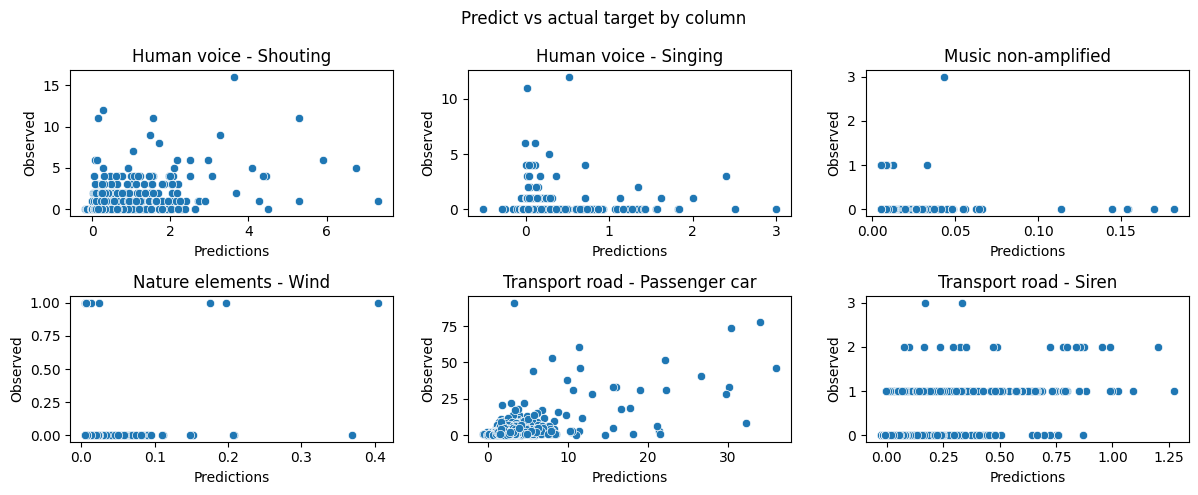

In [39]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharey=False)
for col in range(0,6):
    if col in (0,1,2):
        row = 0
        i = col
    else: 
        row = 1
        i = col-3
    sns.scatterplot(x=predict_val[:,col],y=test_targets.iloc[:,col] ,label=None, ax=axs[row,i])
    axs[row,i].set_title(test_targets.columns[col])
    axs[row,i].set_xlabel("Predictions")
    axs[row,i].set_ylabel("Observed")
# Formating 
fig.suptitle("Predict vs actual target by column")

plt.tight_layout()
plt.show()